In [79]:
%matplotlib inline

import os
# running with non gpu singularity container, so commented out the next line to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
tf.set_random_seed(42)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print "import tensorflow"
           
import keras.backend.tensorflow_backend as K

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Lambda
from keras.layers import Input, merge, Concatenate, concatenate, Add, Multiply
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop,Adadelta
print "import keras"

import numpy as np
# from tqdm import tqdm
import time
import pickle
import sys
import glob
import hashlib

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

print "import matplotlib"

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import binned_statistic_2d
from scipy.stats import ks_2samp


print "import sklearn"

np.random.seed(42)
cov_hash = None
cov_ans = None


import tensorflow
import keras
import matplotlib
import sklearn


In [80]:
def Minv(cols,ptetaphi=False,nopy2=True):
    """
    Computes M for two objects given the cartesian momentum projections
    if `ptetaphi` is True, then assumes the 8 input columns are cylindrical eptetaphi
    if `nopy2` is True, input is 7 columns with no py2
    """
    if ptetaphi:
        cols = ptetaphi_to_cartesian(cols)
    if nopy2:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]          )**2
        M2 -= (cols[:,3]+cols[:,6])**2
    else:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]+cols[:,6])**2
        M2 -= (cols[:,3]+cols[:,7])**2
    return np.sqrt(M2)

def cartesian_to_ptetaphi(eight_cartesian_cols):
    """
    Takes 8 columns as cartesian e px py pz e px py pz
    and converts to e pt eta phi e pt eta phi
    """
    e1 =  eight_cartesian_cols[:,0]
    e2 =  eight_cartesian_cols[:,4]
    px1 = eight_cartesian_cols[:,1]
    px2 = eight_cartesian_cols[:,5]
    py1 = eight_cartesian_cols[:,2]
    py2 = eight_cartesian_cols[:,6]
    pz1 = eight_cartesian_cols[:,3]
    pz2 = eight_cartesian_cols[:,7]
    p1 = np.sqrt(px1**2+py1**2+pz1**2)
    p2 = np.sqrt(px2**2+py2**2+pz2**2)
    pt1 = np.sqrt(px1**2+py1**2)
    pt2 = np.sqrt(px2**2+py2**2)
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    eta1 = np.arctanh(pz1/p1)
    eta2 = np.arctanh(pz2/p2)
    return np.c_[e1,pt1,eta1,phi1,e2,pt2,eta2,phi2]

def ptetaphi_to_cartesian(eight_eptetaphi_cols):
    """
    Takes 8 columns as e pt eta phi e pt eta phi
    and converts to e px py pz e px py pz
    """
    e1 =  eight_eptetaphi_cols[:,0]
    e2 =  eight_eptetaphi_cols[:,4]
    pt1 =  eight_eptetaphi_cols[:,1]
    pt2 =  eight_eptetaphi_cols[:,5]
    eta1 =  eight_eptetaphi_cols[:,2]
    eta2 =  eight_eptetaphi_cols[:,6]
    phi1 =  eight_eptetaphi_cols[:,3]
    phi2 =  eight_eptetaphi_cols[:,7]
    px1 = np.abs(pt1)*np.cos(phi1)
    px2 = np.abs(pt2)*np.cos(phi2)
    py1 = np.abs(pt1)*np.sin(phi1)
    py2 = np.abs(pt2)*np.sin(phi2)
    pz1 = np.abs(pt1)/np.tan(2.0*np.arctan(np.exp(-1.*eta1)))
    pz2 = np.abs(pt2)/np.tan(2.0*np.arctan(np.exp(-1.*eta2)))
    return np.c_[e1,px1,py1,pz1,e2,px2,py2,pz2]

def get_dphi(px1,py1,px2,py2):
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi 
    return dphi

def M4(E,px,py,pz):
    return np.sqrt(E*E - px*px - py*py - pz*pz)


In [81]:
def invmass_from_8cartesian_nopy2(x):
    
    invmass = K.sqrt(
                (x[:,0:1]+x[:,4:5])**2-
                (x[:,1:2]+x[:,5:6])**2-
                (x[:,2:3]         )**2-
                (x[:,3:4]+x[:,6:7])**2
                )
    return invmass

def lep1mass_from_8cartesian_nopy2(x):
    
    invmass = K.sqrt(
                (x[:,0:1])**2-
                (x[:,1:2])**2-
                (x[:,2:3])**2-
                (x[:,3:4])**2
                )
    return invmass

def lep2mass_from_8cartesian_nopy2(x):
    
    invmass = K.sqrt(
                (x[:,4:5])**2-
                (x[:,5:6])**2-
                (x[:,6:7])**2
                )
    return invmass


# def getKS(real_data, predictions):
#     return ks_2samp(real_data["mll"], Minv(predictions))

def getKS(real_data, predictions):
    return {  "mll" : ks_2samp(real_data["mll"], Minv(predictions))[0],
         "lep1_e"   : ks_2samp(real_data["lep1_e"], predictions[:,0])[0],
         "lep1_px"  :  ks_2samp(real_data["lep1_px"], predictions[:,1])[0],
         "lep1_py"  :  ks_2samp(real_data["lep1_py"], predictions[:,2])[0],
         "lep1_pz"  :  ks_2samp(real_data["lep1_pz"], predictions[:,3])[0],
         "lep2_e"   :  ks_2samp(real_data["lep2_e"], predictions[:,4])[0],
         "lep2_px"  :  ks_2samp(real_data["lep2_px"], predictions[:,5])[0],
         "lep2_pz"  :  ks_2samp(real_data["lep2_pz"], predictions[:,6])[0],
         "nvtxs"    :  ks_2samp(real_data["nvtxs"], np.rint(predictions[:,7]))[0],
         "lep1_iso" :  ks_2samp(real_data["lep1_iso"], predictions[:,8])[0],
         "lep2_iso" :  ks_2samp(real_data["lep2_iso"], predictions[:,9])[0],
         "metx"     :  ks_2samp(real_data["met"]*np.cos(real_data["metphi"]), predictions[:,10])[0],
         "mety"     :  ks_2samp(real_data["met"]*np.sin(real_data["metphi"]), predictions[:,11])[0],
         "met"      :  ks_2samp(real_data["met"], np.hypot(predictions[:,10],predictions[:,11]))[0],
         "metphi"   :  ks_2samp(real_data["metphi"], np.arctan2(predictions[:,11],predictions[:,10]))[0],
         "jet_pt1"  :  ks_2samp(real_data["jet_pt1"], predictions[:,12])[0],
         "jet_pt2"  :  ks_2samp(real_data["jet_pt2"], predictions[:,13])[0],
         "jet_pt3"  :  ks_2samp(real_data["jet_pt3"], predictions[:,14])[0],
         "jet_pt4"  :  ks_2samp(real_data["jet_pt4"], predictions[:,15])[0],
         "jet_pt5"  :  ks_2samp(real_data["jet_pt5"], predictions[:,16])[0] }

def onetime(func):
    """stores the functions output, returns the output if called again on the same input, else computes new output"""
    def decorated(*args, **kwargs):
        global cov_ans
        global cov_hash
        new_hash=hashlib.md5(str(args)+str(kwargs)).hexdigest() 
        if new_hash != cov_hash:
            #print("computing")
            cov_ans = func(*args, **kwargs)
        cov_hash=new_hash
        return cov_ans
    return decorated
    

@onetime
def covariance_metrics(real_data, predictions):
    """Takes in real_data matrix with real entries as rows and predictions matrix with generated events as rows and returns the covariance matricies for the two as well as the average, maximum, and std. dev of the difference between the entries in the coverance matrix as well as in the average of the variables."""
    
    cov_pred = np.cov(predictions.T)
    avg_pred = predictions.mean(axis=0)
    cov_real = np.cov(real_data.T)
    avg_real = real_data.mean(axis=0)
    
    #cov_diff = np.abs((cov_pred - cov_real)/np.sqrt(np.abs(np.outer(avg_real, avg_pred))))
    cov_diff = np.abs((cov_pred - cov_real)/cov_real)
    ar=avg_real
    ar[ar == 0] = 1
    avg_diff = np.abs((avg_pred - avg_real)/ar)
    
    return cov_diff, avg_diff

def get_score(real_data, predictions, weight_cov = (1/361.), weight_avg = (1/19.)):
    cov_diff, avg_diff = covariance_metrics(real_data, predictions)
    return weight_cov*np.sum(cov_diff)+weight_avg*np.sum(avg_diff)

# def get_first_N(x,N):
#     return x[:,0:N]

# def fix_outputs(x):
#     """
#     Take nominal delphes format of 19 columns and fix some columns
#     """
#     return K.concatenate([
#         # x[:,0:21],
#         x[:,0:7], # epxpypz for lep1,lep2 -1 for no py2
#         x[:,7:8], # nvtx
#         K.sign(x[:,8:10]), # q1 q2
#         x[:,10:12], # iso1 iso2
#         x[:,12:14], # met, metphi
#         x[:,14:19], # jet pts
#         ])



In [82]:
def make_plots(preds,reals,title="",fname="",show_pred=True,show_real=True,wspace=0.1,hspace=0.3,tightlayout=True,visible=True):
    nrows, ncols = 5,5
    fig, axs = plt.subplots(nrows,ncols,figsize=(16,13))
#     fig, axs = plt.subplots(nrows,ncols,figsize=(12,10))
#     fig.subplots_adjust(wspace=0.1,hspace=0.3)
    fig.subplots_adjust(wspace=wspace,hspace=hspace)


    info = [
        ["lep1_e",(0,250,50)],
        ["lep1_px",(-100,100,50)],
        ["lep1_py",(-100,100,50)],
        ["lep1_pz",(-200,200,50)],
        ["lep2_e",(0,250,50)],
        ["lep2_px",(-100,100,50)],
        ["lep2_pz",(-200,200,50)],
        ["nvtxs",(0,50,350)],
        ["metx",(-50,50,100)],
        ["mety",(-50,50,100)],
#         ["lep1_charge",(-7,7,30)],
#         ["lep2_charge",(-7,7,30)],
        ["lep1_iso",(0,2.0,30)],
        ["lep2_iso",(0,2.0,30)],
        ["jet_pt1",(0,100,50)],
        ["jet_pt2",(0,100,50)],
        ["jet_pt3",(0,100,50)],
        ["jet_pt4",(0,100,50)],
        ["jet_pt5",(0,100,50)],
        # derived features
        ["dphi",(-4,4,50)],
        ["met",(0,150,50)],
        ["metphi",(-6,6,50)],
        ["mll",(60,120,50)],
        ["lep1_mass",(0,10,50)],
        ["lep2_mass",(0,10,50)],
        ["njets",(0,7,7)],
    ]
    for axx in axs:
        for ax in axx:
            ax.get_yaxis().set_visible(False)
            # turn off all axis borders, and turn them on below so they only show
            # up for axes we've plotted in
            ax.axis('off')
    for ic,(cname,crange) in enumerate(info):
        if cname == "mll":
            real = reals["mll"]
            pred = Minv(preds)
        elif cname == "lep1_mass": real, pred = M4(reals["lep1_e"], reals["lep1_px"], reals["lep1_py"], reals["lep1_pz"]), M4(preds[:,0], preds[:,1], preds[:,2], preds[:,3])
        elif cname == "lep2_mass": real, pred = M4(reals["lep2_e"], reals["lep2_px"], 0, reals["lep2_pz"]), M4(preds[:,4], preds[:,5], preds[:,6], preds[:,7])
        elif cname == "lep1_e": real, pred = reals[cname], preds[:,0]
        elif cname == "lep1_pz": real, pred = reals[cname], preds[:,3]
        elif cname == "lep2_e": real, pred = reals[cname], preds[:,4]
        elif cname == "lep2_pz": real, pred = reals[cname], preds[:,6]
        elif cname == "lep1_px": 
            real = reals[cname]
            pred = preds[:,1]
        elif cname == "lep1_py":
            real = reals[cname]
            pred = preds[:,2]
        elif cname == "lep2_px":
            real = reals[cname]
            pred = preds[:,5]
        elif cname == "dphi":
            real = get_dphi(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], np.zeros(len(reals)))
            pred = get_dphi(preds[:,1], preds[:,2], preds[:,5], np.zeros(len(preds)))
        elif cname == "nvtxs": real, pred = reals[cname], np.round(preds[:,7])
#         elif cname == "lep1_charge": real, pred = reals[cname], preds[:,8]
#         elif cname == "lep2_charge": real, pred = reals[cname], preds[:,9]
        elif cname == "lep1_iso": real, pred = reals[cname], preds[:,8]
        elif cname == "lep2_iso": real, pred = reals[cname], preds[:,9]
        elif cname == "metx": real, pred = reals["met"]*np.cos(reals["metphi"]), preds[:,10]
        elif cname == "mety": real, pred = reals["met"]*np.sin(reals["metphi"]), preds[:,11]
        elif cname == "met": real, pred = reals["met"], np.hypot(preds[:,10],preds[:,11])
        elif cname == "metphi": real, pred = reals["metphi"], np.arctan2(preds[:,11],preds[:,10])
        elif cname == "jet_pt1": real, pred = reals[cname], preds[:,12]
        elif cname == "jet_pt2": real, pred = reals[cname], preds[:,13]
        elif cname == "jet_pt3": real, pred = reals[cname], preds[:,14]
        elif cname == "jet_pt4": real, pred = reals[cname], preds[:,15]
        elif cname == "jet_pt5": real, pred = reals[cname], preds[:,16]
        elif cname == "njets":
            real = \
                1*(reals["jet_pt1"] > 15) + \
                1*(reals["jet_pt2"] > 15) + \
                1*(reals["jet_pt3"] > 15) + \
                1*(reals["jet_pt4"] > 15) + \
                1*(reals["jet_pt5"] > 15)
            pred = \
                1*(preds[:,12] > 15) + \
                1*(preds[:,13] > 15) + \
                1*(preds[:,14] > 15) + \
                1*(preds[:,15] > 15) + \
                1*(preds[:,16] > 15)
        idx = ic // ncols, ic % ncols
        if show_real:
            bins_real = axs[idx].hist(real, range=crange[:2],bins=crange[-1], histtype="step", lw=1.5,density=True)
        if show_pred:
            bins_pred = axs[idx].hist(pred, range=crange[:2],bins=crange[-1], histtype="step", lw=1.5,density=True)
        axs[idx].set_xlabel("{}".format(cname),fontsize=14)
        axs[idx].axis('on')
        if cname in ["mll","lep1_mass","lep2_mass","dphi","met","metphi","njets"]:
            axs[idx].xaxis.label.set_color('blue')
    #     axs[idx].set_yscale("log", nonposy='clip')
    _ = axs[0,0].legend(["True","Pred"], loc='upper right',fontsize=14)
    _ = axs[0,0].set_title(title)
    if tightlayout:
        plt.tight_layout()
    if fname:
        fig.savefig(fname)
    if not visible:
        plt.close(fig)
        

In [83]:
def get_recview(data, dtype="<f4"):
    """
    for example, can give it a matrix of values predicted by generator
    and this gives a view of the same matrix with dtypes (for easier column selection)
    if weird results, like 2 columns per field, use dtype="<f8"
    """
    cnames = [
    "lep1_e",
    "lep1_px",
    "lep1_py",
    "lep1_pz",
    "lep2_e",
    "lep2_px",
    "lep2_pz",
    "nvtxs",
#     "lep1_charge",
#     "lep2_charge",
    "lep1_iso",
    "lep2_iso",
    "metx",
    "mety",
    "jet_pt1",
    "jet_pt2",
    "jet_pt3",
    "jet_pt4",
    "jet_pt5",
    ]
    cnames = [(cn,dtype) for cn in cnames]
    return data.view(dtype=cnames)

## GAN class
Instantiate the GAN class, then add methods piece by piece (by making a "new" class inheriting from the original).
I did this so that all these long functions could go into different cells, which makes it easier to navigate/read.

In [91]:
class GAN():
    def __init__(self, **kwargs):

        self.args = dict(kwargs)

        self.verbose = kwargs.get("verbose",True)
        self.tag = kwargs["tag"]
        self.input_file = str(kwargs["input_file"])
        self.noise_shape = (int(kwargs["noise_size"]),)
        self.output_shape = (int(kwargs["output_size"]),)
        self.noise_type = int(kwargs["noise_type"])
        self.ntest_samples = int(kwargs["ntest_samples"])
        self.nepochs_dump_pred_metrics = int(kwargs["nepochs_dump_pred_metrics"])
        self.nepochs_dump_models = int(kwargs["nepochs_dump_models"])
        self.nepochs_dump_plots = int(kwargs["nepochs_dump_plots"])
        self.nepochs_max = int(kwargs["nepochs_max"])
        self.batch_size = int(kwargs["batch_size"])
        self.do_soft_labels = kwargs["do_soft_labels"]
        self.do_noisy_labels = kwargs["do_noisy_labels"]
        self.nepochs_decay_noisy_labels = int(kwargs["nepochs_decay_noisy_labels"])
        self.optimizer_gen = kwargs["optimizer_gen"]
        self.optimizer_disc = kwargs["optimizer_disc"]
        self.depth_disc = kwargs["depth_disc"]
        self.width_disc = kwargs["width_disc"]
        self.depth_gen = kwargs["depth_gen"]
        self.width_gen = kwargs["width_gen"]
        self.beefy_generator = kwargs["beefy_generator"]
        self.beefy_discriminator = kwargs["beefy_discriminator"]
#         self.fix_delphes_outputs = kwargs["fix_delphes_outputs"]
        self.use_mll_loss = kwargs["use_mll_loss"]
        self.loss_mll_weight = kwargs["loss_mll_weight"]
        self.terminate_early = kwargs["terminate_early"]
        self.loss_type = kwargs["loss_type"]
        self.dropout_discriminator = kwargs["dropout_discriminator"]
        self.frac_true = kwargs["frac_true"]
        self.outdir = kwargs["outdir"]

        self.scaler_type = kwargs["scaler_type"]
        self.scaler = None
        self.jetscaler = None
        self.isoscaler = None
        
        self.initialize()
        
    def initialize(self):
        if self.scaler_type.lower() == "minmax":
            self.scaler = MinMaxScaler(feature_range=(-1.,1.))
        elif self.scaler_type.lower() == "robust":
            self.scaler = RobustScaler()
        elif self.scaler_type.lower() == "standard":
            self.scaler = StandardScaler()
        else:
            if "jet" in self.scaler_type.lower():
                print "Scaling jet pts"
                #self.jetscaler = MinMaxScaler(feature_range=(-1.,1.))
                self.jetscaler = RobustScaler()
            if "iso" in self.scaler_type.lower():
                print "Scaling lep isos"
                #self.isoscaler = MinMaxScaler(feature_range=(-1.,1.))
                self.isoscaler = RobustScaler()

        self.data = None
        self.data_ref = None
        self.d_epochinfo = {}
        self.X_train = None

        optimizer_d = self.optimizer_disc
        optimizer_g = self.optimizer_gen
        
        def dosplit(x):
            return float(x.split("=")[1].split(")")[0].strip())
        if "lr" in self.optimizer_disc: optimizer_d = Adadelta(lr=dosplit(self.optimizer_disc))
        if "lr" in self.optimizer_gen: optimizer_g = Adadelta(lr=dosplit(self.optimizer_gen))

        # Build and compile the discriminator
        if self.use_mll_loss:
            loss = self.custom_loss(c=self.loss_mll_weight, loss_type=self.loss_type)
        else:
            loss = "binary_crossentropy"
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=self.custom_loss(0, "disc"),
            optimizer=optimizer_d,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=loss, optimizer=optimizer_g)

        # The generator takes noise as input and generated imgs
        z = Input(shape=self.noise_shape)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss=loss, optimizer=optimizer_g)


In [92]:
class GAN(GAN):
    
    def custom_loss(self, c, loss_type = "force_mll"):
        mu_z, sig_z = 89.6, 7.73
        mu_l, sig_l = 0.105, 0.019
        if loss_type == "disc":
            def loss_func(y_true, y_pred_mll):
                y_true = y_true[:,0]
                y_pred = y_pred_mll[:,0]
                return binary_crossentropy(y_true, y_pred)
            return loss_func
        elif loss_type == "force_mll":
            def loss_func(y_true, y_pred_mll):
                y_true = y_true[:,0]
                y_pred = y_pred_mll[:,0]
                mll_pred = y_pred_mll[:,1]
                mll_loss = K.mean(K.abs(mll_pred - mu_z))
                return binary_crossentropy(y_true, y_pred) + c*mll_loss
            return loss_func
        elif loss_type == "force_z_width":
            def loss_func(y_true, y_pred_mll):
                y_true = y_true[:,0]
                y_pred = y_pred_mll[:,0]
                mll_pred = y_pred_mll[:,1]
                mll_loss = K.mean((mll_pred - mu_z)**2)
                mll_sigma_loss = (K.std(mll_pred)-sig_z)**2

                return binary_crossentropy(y_true, y_pred) + c*mll_loss + c*mll_sigma_loss
            return loss_func
        elif loss_type == "lepmass":
            def loss_func(y_true, y_pred_mll):
                y_true = y_true[:,0]
                y_pred = y_pred_mll[:,0]
                
                mll_pred = y_pred_mll[:,1]
                l1m_pred = y_pred_mll[:,2]
                l2m_pred = y_pred_mll[:,3]
                
                mll_loss = K.mean((mll_pred - mu_z)**2)
                mll_sigma_loss = (K.std(mll_pred)-sig_z)**2
                l1_loss = K.mean((l1m_pred - mu_l)**2)
                l1_sigma_loss = (K.std(l1m_pred)-sig_l)**2
                l2_loss = K.mean((l2m_pred - mu_l)**2)
                l2_sigma_loss = (K.std(l2m_pred)-sig_l)**2

                return binary_crossentropy(y_true, y_pred) + c*mll_loss + c*mll_sigma_loss + c*c*K.log(l1_loss) + c*c*K.log(l1_sigma_loss) + c*c*K.log(l2_loss) + c*c*K.log(l2_sigma_loss)
            return loss_func
        else:
            raise ValueError("Can not make loss function of type %s" % loss_type)
        
    def build_generator(self):

        inputs = Input(shape=self.noise_shape)

        ## Head
        x = Dense(64)(inputs)
        x = LeakyReLU(alpha=0.2)(x)
        if self.depth_gen > 0 and self.width_gen > 0:
            for level in xrange(0,self.depth_gen):
                x = Dense(width_gen/(2**level))(x) #Triangle with width halved at each level
                x = LeakyReLU(alpha=0.2)(x)
        elif self.beefy_generator:
            for size in [128,256,512,256,128]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)
        else:
            for size in [128,128,128,64,32]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)
 
    
        x = Dense(self.output_shape[0], activation="linear")(x)
            
#         if self.fix_delphes_outputs:
#             x = Lambda(fix_outputs,
#                 input_shape=self.output_shape,
#                 output_shape=self.output_shape
#                 )(x)
            
        model = Model(inputs=inputs, outputs=[x])
        
        print "Generator params: {}".format(model.count_params())
        if self.verbose:
            model.summary()
        
        return model
    
class GAN(GAN):
    
    def build_discriminator(self):

        inputs = Input(self.output_shape)
        mll = Lambda(invmass_from_8cartesian_nopy2)(inputs)
        lep1m = Lambda(lep1mass_from_8cartesian_nopy2)(inputs)
        lep2m = Lambda(lep2mass_from_8cartesian_nopy2)(inputs)
        x = Dense(128)(inputs)
        x = LeakyReLU(alpha=0.2)(x)

        ## Main Body
        if self.depth_disc > 0 and self.width_disc > 0:
            for level in xrange(0,self.depth_disc):
                x = Dense(self.width_disc/(2**level))(x) #Triangle with width halved at each level
                x = LeakyReLU(alpha=0.2)(x)
        elif self.beefy_discriminator:
            for size in [128,256,256,128,64,32,16,8]:
                x = Dense(size)(x)
                if self.dropout_discriminator:
                    x = Dropout(0.1)(x)
                x = LeakyReLU(alpha=0.2)(x)
        else:
            for size in [128]*5 + [64,32,16,8]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)

        ## Tail
        out = Dense(1,activation='sigmoid')(x)
        
        if self.use_mll_loss:
            if self.loss_type == "lepmass":
                model = Model(inputs=inputs, outputs=concatenate([out,mll,lep1m,lep2m]))
            else:
                model = Model(inputs=inputs, outputs=concatenate([out,mll]))
        else:
            model = Model(inputs=inputs, outputs=out)
#         print model.output_shape
        if self.verbose:
            model.summary()
        print "Discriminator params: {}".format(model.count_params())
        
        return model
        

In [93]:
class GAN(GAN):
    
    def load_data(self):
        if self.data is not None: return
        
        self.data = np.load(self.input_file)
            
        # make sure we drop low mass resonances
        self.data = self.data[self.data["genmll"] > 50.]
        
    def make_flat_array(self):
        """Builds X_train array which is a flat version of the self.data that has any scaling or modifications applied"""
        
        lepcoords = np.c_[
            self.data["lep1_e"],
            self.data["lep1_px"],
            self.data["lep1_py"],
            self.data["lep1_pz"],
            self.data["lep2_e"],
            self.data["lep2_px"],
            self.data["lep2_pz"],
        ]

        nvtx_smeared = np.round(np.random.normal(self.data["nvtxs"],0.5))
        
        isocoords = np.c_[self.data["lep1_iso"], 
                          self.data["lep2_iso"]]
        if self.isoscaler:
            print "scaling lepton isolations"
            self.isoscaler.fit(isocoords)
            isocoords = self.isoscaler.transform(isocoords).astype(np.float32)
            pickle.dump(self.isoscaler, open("{}/progress/{}/isoscaler.pkl".format(self.outdir,self.tag),'w'))
        
        jetcoords = np.c_[self.data["jet_pt1"],
                          self.data["jet_pt2"],
                          self.data["jet_pt3"],
                          self.data["jet_pt4"],
                          self.data["jet_pt5"]]
        
        if self.jetscaler:
            print "scaling jet pts"
            self.jetscaler.fit(jetcoords)
            jetcoords = self.jetscaler.transform(jetcoords).astype(np.float32)
            pickle.dump(self.jetscaler, open("{}/progress/{}/jetscaler.pkl".format(self.outdir,self.tag),'w'))
        
        self.X_train = np.c_[
            lepcoords, # 7 columns
            nvtx_smeared, # 1 column
            isocoords,
            self.data["met"]*np.cos(self.data["metphi"]), # metx
            self.data["met"]*np.sin(self.data["metphi"]), # mety
            jetcoords
        ].astype(np.float32)

        # # NOTE. StandardScaler should be fit on training set
        # # and applied the same to train and test, otherwise we
        # # introduce a bias
        if self.scaler:
            self.scaler.fit(self.X_train)
            self.X_train = self.scaler.transform(self.X_train).astype(np.float32)
            pickle.dump(self.scaler, open("{}/progress/{}/scaler.pkl".format(self.outdir,self.tag),'w'))
        

    def get_noise(self, amount=1024, max_true_samples=-1, max_true_samples_frac=-1):
        """
        `amount` specifies number of noise vectors
        `max_true_samples` applies only to truth conditioned noise type
            if > 0, then the true samples are sampled from the first 
            `max_true_samples` of real events (by default, all are allowed)
        `max_true_samples_frac` same desc as `max_true_samples`, but specified
            instead as fraction of `amount`
        """
        # nominal
        if self.noise_type == 1:
            noise_half = np.random.normal(0, 1, (amount//2, self.noise_shape[0]))
            noise_full = np.random.normal(0, 1, (amount, self.noise_shape[0]))

        elif self.noise_type == 2: # random soup, 4,2,2 have to be modified to sum to noise_shape[0]
            ngaus = self.noise_shape[0] // 2
            nflat = (self.noise_shape[0] - ngaus) // 2
            nexpo = self.noise_shape[0] - nflat - ngaus
            noise_gaus = np.random.normal( 0, 1, (amount//2+amount, ngaus))
            noise_flat = np.random.uniform(-1, 1, (amount//2+amount, nflat))
            noise_expo = np.random.exponential( 1,    (amount//2+amount, nexpo))
            noise = np.c_[ noise_gaus,noise_flat,noise_expo ]
            noise_half = noise[:amount//2]
            noise_full = noise[-amount:]
        elif self.noise_type == 3: #Flat noise between 0-1, last 4 units are flipped negative
            noise_half = np.random.uniform(0, 1, (amount//2, self.noise_shape[0]))
            noise_half[:,-4:] *= -1
            noise_full = np.random.uniform(0, 1, (amount, self.noise_shape[0]))
            noise_full[:,-4:] *= -1
            
            
        return noise_half, noise_full
    
    def getTrialNums(self):
        """Looks for directories with the same tag but different _num at the end, returns a list of the nums"""
        tag_nonum = self.tag[:self.tag.rfind('_')]
        dirs = []
        dirnums = []
        for d in os.listdir("%s/progress/" % (self.outdir)):
            if tag_nonum in d:
                dirnums.append(int(d[d.rfind('_')+1:]))
        return dirnums
    
    def get_available_checkpoints(self, trial=None):
        # check the output folder for all weights files and return list of epochs for existing files
        if self.tag[-1].isdigit():
            tag_regex = self.tag[:self.tag.rfind('_')]+"*"
            fnames = glob.glob("{}/progress/{}/gen_*.weights".format(self.outdir,tag_regex))
        elif trial:
            tag_trail = self.tag[:self.tag.rfind('_')]+"_%d" % trial
            fnames = glob.glob("{}/progress/{}/gen_*.weights".format(self.outdir,tag_trail))
        else:
            fnames = glob.glob("{}/progress/{}/gen_*.weights".format(self.outdir,self.tag))
        return np.array(sorted(map(lambda x: int(x.rsplit("_",1)[1].split(".")[0]), fnames)))

    def load_checkpoint(self, epoch, trial=None):
        """given an epoch number, load the disc/gen files, overriding self.discriminator/self.generator
        need to give custom_objects to load_model because keras doesn't know what the loss function is otherwise"""
        custom = {"loss_func": gan.custom_loss(c=self.loss_mll_weight,loss_type=self.loss_type)}
        # make sure data is loaded if we just want to make a gan, load a checkpoint, and predict + pull real samples
        self.load_data()
        
        if trial:
            tag = self.tag[:self.tag.rfind('_')]+"_%d" % trial
            self.tag=tag
        else:
            tag = self.tag
            
        self.discriminator = load_model("{}/progress/{}/disc_{}.weights".format(self.outdir,tag,epoch),custom_objects=custom)
        self.generator = load_model("{}/progress/{}/gen_{}.weights".format(self.outdir,tag,epoch),custom_objects=custom)
        self.d_epochinfo = pickle.load(open("{}/progress/{}/history.pkl".format(self.outdir,tag),'r'))

        
    def load_last_checkpoint(self,which=-1):
        # convenience function to get last available checkpoint and load it (or `which`th from last)
        lastepoch = self.get_available_checkpoints()[which]
        print "Loading last checkpoint for tag {}: epoch {}".format(self.tag, lastepoch)
        self.load_checkpoint(lastepoch)
        
    def predict(self, N, frac):
        """Gets prediction from trained generator and undoes any scaling."""
        _, noise = self.get_noise(N,max_true_samples_frac=frac)
        # print preds.shape
        preds = self.generator.predict(noise,verbose=1)
        
        if self.scaler:
            preds = self.scaler.inverse_transform(preds)
            return preds
        
        lepcoords = preds[:,0:7]
        nvtx = preds[:,7]
        isocoords = preds[:,8:10]
        metcoords = preds[:,10:12]
        jetcoords = preds[:,12:17]
        if self.isoscaler:
            isocoords = self.isoscaler.inverse_transform(isocoords)
        if self.jetscaler:
            jetcoords = self.jetscaler.inverse_transform(jetcoords)
            
        return  np.c_[
                lepcoords, # 7 columns
                nvtx, # 1 column
                isocoords,
                metcoords,
                jetcoords
            ].astype(np.float32)

## Batch Training Metrics

In this block we impliment running through the batch training metrics for all the models in the current tag and finding the best models based on those metrics.

In [94]:
class GAN(GAN):
    
    def findBest(self, metrics=["mll", "metphi", "lep1_iso"]):
        trial_info = []
        tag_nonum = self.tag[:self.tag.rfind('_')]
        for i in self.getTrialNums():
            trial_log = pickle.load( open("%s/progress/%s_%d/history.pkl" % (self.outdir, tag_nonum, i)) )
            trial_info += zip(np.zeros(len(trial_log["epoch"]))+i, trial_log["epoch"], trial_log["ks"])

        #print trial_info   

        sorted_trials = {}

        #Get dict of epoch lists, each list is sorted by the metric 'm'
        for m in metrics:
            sorted_trials[m] = list(enumerate(np.array(sorted(trial_info, key = lambda x: 2 if math.isnan(x[2][m]) else x[2][m]))[:,0:2]))

        #print sorted_trials["g_loss"]

        epoch_score = {}
        for row in sorted_trials[metrics[0]]:
            epoch_score["%d_%d" % (row[1][0], row[1][1])] = [row[0], {metrics[0]: row[0]}]

        for m in metrics[1:]:
            for row in sorted_trials[m]:
                epoch_score["%d_%d" % (row[1][0], row[1][1])][0] += row[0]
                epoch_score["%d_%d" % (row[1][0], row[1][1])][1][m] = row[0]

        return sorted(epoch_score.items(), key=lambda k: k[1][0])
            
        

In [95]:
class GAN(GAN):
            
    def train(self, trial=1):

        self.load_data()
        self.make_flat_array()
        
        # make an alias to save typing
        X_train = self.X_train
        
        half_batch = int(self.batch_size / 2)

        prev_gen_loss = -1
        prev_disc_loss = -1
        n_loss_same_gen = 0  # number of epochs for which generator loss has remained ~same (within 0.01%)
        n_loss_same_disc = 0  # number of epochs for which discriminator loss has remained ~same (within 0.01%)
        old_info = -1, -1
        ks_score = 999.
        best_ks_score = 999.
        
        os.system("mkdir -p {}/progress/{}/".format(self.outdir,self.tag))
        os.system("cp gan_reco_Sep12_bobak.ipynb {}/progress/{}/".format(self.outdir,self.tag))
        logfile = open("{}/progress/{}/log.txt".format(self.outdir,self.tag),'w+')
        logfile.write("Getting Started! Copied notebook into progress directory.\n")
        
        for epoch in range(self.nepochs_max):

            if self.terminate_early:
                if n_loss_same_gen > 1000 or n_loss_same_disc > 1000:
                    print "BREAKING because disc/gen loss has remained the same for {}/{} epochs!".format(n_loss_same_disc,n_loss_same_gen)
                    break

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            
            noise_half, noise_full = self.get_noise(self.batch_size, max_true_samples_frac=self.frac_true)
            
            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise_half)

            # Train the discriminator
            ones = np.ones((half_batch, 1))
            zeros = np.zeros((half_batch, 1))

            if self.do_soft_labels:
                ones *= 0.9

            if self.do_noisy_labels:
                frac = 0.3*np.exp(-epoch/self.nepochs_decay_noisy_labels)
                if frac > 0.005:
                    ones[np.random.randint(0, len(ones), int(frac*len(ones)))] = 0
                    zeros[np.random.randint(0, len(zeros), int(frac*len(zeros)))] = 1

            d_loss = self.discriminator.train_on_batch(np.concatenate([imgs, gen_imgs[:half_batch]]), np.concatenate([ones, zeros]))
            
            # ---------------------
            #  Train Generator
            # ---------------------
            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * self.batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise_full, valid_y)

            if (g_loss - prev_gen_loss) < 0.0001: n_loss_same_gen += 1
            else: n_loss_same_gen = 0
            prev_gen_loss = g_loss

            if (d_loss[0] - prev_disc_loss) < 0.0001: n_loss_same_disc += 1
            else: n_loss_same_disc = 0
            prev_disc_loss = d_loss[0]

            # Plot the progress
#             print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            sys.stdout.write("\r{} [D loss: {}, acc.: {:.2f}%] [G loss: {}] [mll={:.3f}+-{:.3f}] [ks={:.3f}]".format(epoch, d_loss[0], 100.0*d_loss[1], g_loss, old_info[0], old_info[1],ks_score))

            if epoch % self.nepochs_dump_pred_metrics == 0 and epoch > 0:
            
                _, noise_test = self.get_noise(self.ntest_samples,  max_true_samples_frac=self.frac_true)
            
                sys.stdout.write("\n") # break up the stream of text

                gen_imgs = self.generator.predict(noise_test)

                if self.scaler:
                    gen_imgs = self.scaler.inverse_transform(gen_imgs)

                masses = Minv(gen_imgs)
                masses = masses[np.isfinite(masses)]
                old_info = masses.mean(), masses.std()
                ks_scores = getKS(self.data[:15000],gen_imgs)
                ks_scores["stat_score"] = get_score(X_train, gen_imgs)
                ks_score = ks_scores["mll"]

                if "epoch" not in self.d_epochinfo:
                    self.d_epochinfo["epoch"] = []
                    self.d_epochinfo["d_acc"] = []
                    self.d_epochinfo["d_loss"] = []
                    self.d_epochinfo["g_loss"] = []
                    self.d_epochinfo["mass_mu"] = []
                    self.d_epochinfo["mass_sig"] = []
                    self.d_epochinfo["ks"] = []
                    self.d_epochinfo["time"] = []
                    self.d_epochinfo["args"] = self.args
                else:
                    self.d_epochinfo["epoch"].append(epoch)
                    self.d_epochinfo["d_acc"].append(100*d_loss[1])
                    self.d_epochinfo["d_loss"].append(d_loss[0])
                    self.d_epochinfo["g_loss"].append(g_loss)
                    self.d_epochinfo["mass_mu"].append(masses.mean())
                    self.d_epochinfo["mass_sig"].append(masses.std())
                    self.d_epochinfo["ks"].append(ks_scores)
                    self.d_epochinfo["time"].append(time.time())

                pickle.dump(self.d_epochinfo, open("{}/progress/{}/history.pkl".format(self.outdir,self.tag),'w'))

                # note, nested within nepochs_dump_pred_metrics, so below value must be multiple of that
                if epoch % self.nepochs_dump_plots == 0 and epoch > 0:
                    preds = self.predict(self.ntest_samples,self.frac_true)
                    reals = self.data[:15000]
                    _ = make_plots(preds,reals,title="{}: epoch {}".format(self.tag,epoch),
                                   fname="{}/progress/{}/plots_{:06d}.png".format(self.outdir,self.tag,epoch),visible=False)

                # note, nested within nepochs_dump_pred_metrics, so below value must be multiple of that
                if epoch % self.nepochs_dump_models == 0 and epoch > 0:                    
                    dfname = "{}/progress/{}/disc_{}.weights".format(self.outdir,self.tag,epoch)
                    gfname = "{}/progress/{}/gen_{}.weights".format(self.outdir,self.tag,epoch)
                    self.discriminator.save(dfname)
                    self.generator.save(gfname)
                    mll_ks_score = ks_scores["mll"]
                    MetPhi_ks_score = ks_scores["metphi"]
                    Lep1Iso_ks_score = ks_scores["lep1_iso"]
                    logfile.write("epoch %d trial %s StatsScore %f MLLKSStatistic %f METPhiKSStatistic %f Lep1IsoKSStatistic %f \n" % (epoch, trial, ks_scores["stat_score"], ks_scores["mll"], ks_scores["metphi"], ks_scores["lep1_iso"]))
                    logfile.write("\r{} [D loss: {}, acc.: {:.2f}%] [G loss: {}] [mll={:.3f}+-{:.3f}]\n".format(epoch, d_loss[0], 100.0*d_loss[1], g_loss, old_info[0], old_info[1]))
        
        logfile.close()
    
    def batchTrain(self, tag, ntrials=10):
        """Trains the same config ntrials times, does book-keeping for you"""
        trial = 1
        for i in range(1,ntrials):
            tag+="_%d" % i
            self.tag=tag
            self.initialize()
            try:
                self.train(i)
            except Exception as e:
                print("Encountered Error %s" % e)
                continue

## Set parameters and instantiate
Parameters, plots, epoch metrics, get saved to folder `progress/<tag>`.

In [96]:
# defaults
params = {
        "batch_size": 512,
        "beefy_discriminator": True,
        "beefy_generator": True,
        "depth_disc": 0,
        "depth_gen": 0,
        "do_batch_normalization_disc": False,
        "do_batch_normalization_gen": False,
        "do_concatenate_disc": False,
        "do_concatenate_gen": False,
        "do_noisy_labels": False,
        "do_soft_labels": False,
#         "do_noisy_labels": True,
#         "do_soft_labels": True,
        "do_skip_connection": False,
        "do_tanh_gen": False,
        "dropout_discriminator": False,
        "frac_true": -1,
        "input_file": "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa",
        "loss_mll_weight": 0.0001,
#         "loss_type": "force_mll",
        #"loss_type": "force_z_width",
        "loss_type": "lepmass",
        "nepochs_decay_noisy_labels": 1000,
#         "nepochs_dump_models": 9999999, # can't dump models? FIXME
        "nepochs_dump_models": 100, # can't dump models? FIXME
        "nepochs_dump_plots": 500,
        "nepochs_dump_pred_metrics": 100,
        #"nepochs_max": 100001,
        "nepochs_max": 40001,
        "noise_size": 17,
        "noise_type": 3,
        "ntest_samples": 10000,
        "optimizer_disc": "adadelta",
        "optimizer_gen": "adadelta",
#         "optimizer_disc": "adadelta(lr=0.1)",
#         "optimizer_gen": "adadelta(lr=0.1)",
        "output_size": 17,
        #"scaler_type": "jetiso",
        "scaler_type": "None",
        "terminate_early": True,
        "use_mll_loss": True,
        "width_disc": 0,
        "width_gen": 0,
        "verbose": True,
        "outdir": "/nfs-7/userdata/bhashemi/DY-GAN/models",
        #"outdir": "/home/users/bhashemi/Projects/GIT/DY-GAN/gan/notebooks"
        }
params.update({
})
print params
    
# change tag for provenance
params["tag"] = "v3_test"

gan = GAN(**params)


{'do_skip_connection': False, 'width_disc': 0, 'ntest_samples': 10000, 'optimizer_disc': 'adadelta', 'nepochs_dump_models': 100, 'loss_type': 'lepmass', 'input_file': '/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa', 'dropout_discriminator': False, 'terminate_early': True, 'do_batch_normalization_disc': False, 'scaler_type': 'None', 'nepochs_dump_plots': 500, 'batch_size': 512, 'do_concatenate_disc': False, 'do_noisy_labels': False, 'do_soft_labels': False, 'depth_gen': 0, 'nepochs_dump_pred_metrics': 100, 'verbose': True, 'noise_size': 17, 'do_batch_normalization_gen': False, 'outdir': '/nfs-7/userdata/bhashemi/DY-GAN/models', 'output_size': 17, 'frac_true': -1, 'loss_mll_weight': 0.0001, 'nepochs_max': 40001, 'beefy_discriminator': True, 'width_gen': 0, 'depth_disc': 0, 'do_tanh_gen': False, 'do_concatenate_gen': False, 'use_mll_loss': True, 'beefy_generator': True, 'nepochs_decay_noisy_labels': 1000, 'optimizer_gen': 'adadelta', 'noise_type': 3}
_____

## Train

In [ ]:
params["tag"] = "lepflatnoise3"
gan = GAN(**params)
gan.batchTrain("lepflatnoise3", 40)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 17)           0                                            
__________________________________________________________________________________________________
dense_313 (Dense)               (None, 128)          2304        input_53[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_277 (LeakyReLU)     (None, 128)          0           dense_313[0][0]                  
__________________________________________________________________________________________________
dense_314 (Dense)               (None, 128)          16512       leaky_re_lu_277[0][0]            
__________________________________________________________________________________________________
leaky_re_l

100 [D loss: 0.116265542805, acc.: 0.00%] [G loss: 2.40036559105] [mll=-1.000+--1.000] [ks=999.000]]
200 [D loss: 0.0954831838608, acc.: 0.00%] [G loss: 3.25717401505] [mll=12.644+-1.420] [ks=1.000]]
300 [D loss: 0.0738756284118, acc.: 0.00%] [G loss: 4.16508150101] [mll=53.538+-6.320] [ks=0.945]
400 [D loss: 0.0491074770689, acc.: 0.00%] [G loss: 4.18707227707] [mll=45.934+-5.358] [ks=0.966]
500 [D loss: 0.0971423089504, acc.: 0.00%] [G loss: 5.27033567429] [mll=64.386+-7.432] [ks=0.884]
10000/10000 [==============================] - 1s 61us/step


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in sqrt


600 [D loss: 0.0187243316323, acc.: 0.00%] [G loss: 4.96369743347] [mll=52.974+-6.027] [ks=0.947]]
700 [D loss: 0.0545892640948, acc.: 0.00%] [G loss: 4.74828863144] [mll=89.933+-10.453] [ks=0.226]
800 [D loss: 0.0946172550321, acc.: 0.00%] [G loss: 5.60989332199] [mll=74.750+-8.444] [ks=0.734]
900 [D loss: 0.0566033162177, acc.: 0.00%] [G loss: 3.97165679932] [mll=64.787+-7.027] [ks=0.890]
1000 [D loss: 0.0271218121052, acc.: 0.00%] [G loss: 3.47482657433] [mll=70.592+-7.661] [ks=0.826]
10000/10000 [==============================] - 1s 60us/step
1100 [D loss: 0.0385638810694, acc.: 0.00%] [G loss: 4.28246545792] [mll=80.107+-8.336] [ks=0.587]
1200 [D loss: 0.0885897353292, acc.: 0.00%] [G loss: 3.11744523048] [mll=77.228+-7.846] [ks=0.692]
1300 [D loss: 0.0722847878933, acc.: 0.00%] [G loss: 3.03892612457] [mll=79.509+-8.075] [ks=0.616]
1400 [D loss: 0.192727297544, acc.: 0.00%] [G loss: 8.73898601532] [mll=77.054+-7.140] [ks=0.720]]
1500 [D loss: 0.0604627989233, acc.: 0.00%] [G loss

100 [D loss: 0.0504452846944, acc.: 0.00%] [G loss: 6.09108781815] [mll=-1.000+--1.000] [ks=999.000]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice.


200 [D loss: 0.0793833658099, acc.: 0.00%] [G loss: 2.95337057114] [mll=nan+-nan] [ks=1.000]
300 [D loss: 0.365017414093, acc.: 0.00%] [G loss: 2.02338695526] [mll=45.733+-4.872] [ks=0.969]]
400 [D loss: 0.167869433761, acc.: 0.00%] [G loss: 4.09248876572] [mll=49.877+-4.988] [ks=0.961]1]
500 [D loss: 0.188357919455, acc.: 0.00%] [G loss: 2.56744074821] [mll=39.999+-3.834] [ks=0.988]]
10000/10000 [==============================] - 1s 66us/step
600 [D loss: 0.0592795871198, acc.: 0.00%] [G loss: 4.38813066483] [mll=71.149+-6.789] [ks=0.837]
700 [D loss: 1.3364238739, acc.: 0.00%] [G loss: 4.48352241516] [mll=22.705+-2.214] [ks=0.999]]9]
800 [D loss: 0.0311002135277, acc.: 0.00%] [G loss: 4.18136739731] [mll=82.042+-7.188] [ks=0.552]
900 [D loss: 0.0391888618469, acc.: 0.00%] [G loss: 4.20669126511] [mll=59.913+-4.975] [ks=0.934]
1000 [D loss: 0.137930646539, acc.: 0.00%] [G loss: 4.93250322342] [mll=64.792+-5.292] [ks=0.911]
10000/10000 [==============================] - 1s 72us/step
11

14900 [D loss: 0.275162696838, acc.: 0.00%] [G loss: 1.79077708721] [mll=90.087+-9.451] [ks=0.232]
15000 [D loss: 0.313216656446, acc.: 0.00%] [G loss: 1.75499618053] [mll=89.958+-6.242] [ks=0.156]
10000/10000 [==============================] - 1s 58us/step
15100 [D loss: 0.256868153811, acc.: 0.00%] [G loss: 1.81139397621] [mll=90.070+-7.342] [ks=0.158]
15200 [D loss: 0.330031365156, acc.: 0.00%] [G loss: 1.64417266846] [mll=87.861+-4.897] [ks=0.280]
15300 [D loss: 0.291591435671, acc.: 0.00%] [G loss: 1.63956642151] [mll=89.972+-6.742] [ks=0.137]
15400 [D loss: 0.280439019203, acc.: 0.00%] [G loss: 1.88303291798] [mll=90.417+-10.629] [ks=0.196]
15500 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=100.580+-12.687] [ks=0.592] [ks=0.592]
  768/10000 [=>............................] - ETA: 0s

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: Mean of empty slice.


10000/10000 [==============================] - 1s 67us/step


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in less


15600 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=nan+-nan] [ks=1.000]
15700 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=nan+-nan] [ks=1.000]
15800 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=nan+-nan] [ks=1.000]
15900 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=nan+-nan] [ks=1.000]
16000 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=nan+-nan] [ks=1.000]
10000/10000 [==============================] - 1s 76us/step
16100 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=nan+-nan] [ks=1.000]
16200 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=nan+-nan] [ks=1.000]
16300 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=nan+-nan] [ks=1.000]
16400 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=nan+-nan] [ks=1.000]
16480 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=nan+-nan] [ks=1.000]BREAKING because disc/gen loss has remained the same for 1001/0 epochs!
_______________________________________

100 [D loss: 0.342079669237, acc.: 50.00%] [G loss: 1.60910403728] [mll=-1.000+--1.000] [ks=999.000]
200 [D loss: 0.327333569527, acc.: 0.00%] [G loss: 4.07549858093] [mll=nan+-nan] [ks=1.000]]
300 [D loss: 0.111453585327, acc.: 0.00%] [G loss: 4.31909942627] [mll=49.129+-5.171] [ks=0.961]]
400 [D loss: 0.0891220867634, acc.: 0.00%] [G loss: 3.59400606155] [mll=51.197+-5.003] [ks=0.958]]
500 [D loss: 0.51011043787, acc.: 0.00%] [G loss: 3.16450285912] [mll=77.084+-7.398] [ks=0.710]0]
10000/10000 [==============================] - 1s 67us/step
600 [D loss: 0.0769529864192, acc.: 0.00%] [G loss: 3.99172997475] [mll=65.458+-5.854] [ks=0.901]]
700 [D loss: 0.785475194454, acc.: 0.00%] [G loss: 1.62477850914] [mll=107.212+-8.609] [ks=0.827]]
800 [D loss: 0.180782049894, acc.: 0.00%] [G loss: 2.41401934624] [mll=130.057+-11.044] [ks=0.964]]
900 [D loss: 0.121985562146, acc.: 0.00%] [G loss: 3.21455597878] [mll=31.076+-1.979] [ks=0.998]]
1000 [D loss: 0.156403288245, acc.: 0.00%] [G loss: 2.8

100 [D loss: 0.0435382984579, acc.: 0.00%] [G loss: 3.42070221901] [mll=-1.000+--1.000] [ks=999.000]
200 [D loss: 0.173529133201, acc.: 0.00%] [G loss: 3.26238465309] [mll=0.209+-0.030] [ks=1.000]]]
300 [D loss: 0.157982960343, acc.: 0.00%] [G loss: 2.34672546387] [mll=22.374+-2.459] [ks=0.999]]
400 [D loss: 0.061284031719, acc.: 0.00%] [G loss: 3.94566321373] [mll=40.808+-4.236] [ks=0.984]]]
500 [D loss: 0.109905958176, acc.: 0.00%] [G loss: 2.78771209717] [mll=40.560+-3.715] [ks=0.987]]]
10000/10000 [==============================] - 1s 64us/step
600 [D loss: 0.0596599020064, acc.: 0.00%] [G loss: 3.81438994408] [mll=86.664+-8.588] [ks=0.312]
700 [D loss: 0.0593498982489, acc.: 0.00%] [G loss: 3.7574429512] [mll=51.286+-4.556] [ks=0.960]]
800 [D loss: 0.020041776821, acc.: 0.00%] [G loss: 4.29294538498] [mll=78.186+-7.124] [ks=0.689]]
900 [D loss: 0.176859155297, acc.: 0.00%] [G loss: 7.33455276489] [mll=48.805+-4.267] [ks=0.967]]
1000 [D loss: 0.104008808732, acc.: 0.00%] [G loss: 2

14800 [D loss: 0.287393778563, acc.: 0.00%] [G loss: 1.81486880779] [mll=105.805+-18.854] [ks=0.588]
14900 [D loss: 0.299758940935, acc.: 0.00%] [G loss: 1.95523619652] [mll=91.810+-8.857] [ks=0.258]
15000 [D loss: 0.262353152037, acc.: 0.00%] [G loss: 1.94784939289] [mll=84.936+-10.398] [ks=0.413]
10000/10000 [==============================] - 1s 72us/step
15100 [D loss: 0.253222554922, acc.: 0.00%] [G loss: 1.82469928265] [mll=94.284+-7.727] [ks=0.357]
15200 [D loss: 0.311540693045, acc.: 0.00%] [G loss: 1.8434458971] [mll=87.354+-7.617] [ks=0.234]]
15300 [D loss: 0.266329616308, acc.: 0.00%] [G loss: 1.77889358997] [mll=90.803+-5.426] [ks=0.116]
15400 [D loss: 0.285477846861, acc.: 0.00%] [G loss: 1.72245693207] [mll=89.082+-6.761] [ks=0.227]
15500 [D loss: 0.290999054909, acc.: 0.00%] [G loss: 1.90340411663] [mll=90.029+-6.111] [ks=0.150]
10000/10000 [==============================] - 1s 64us/step
15600 [D loss: 0.320180684328, acc.: 0.00%] [G loss: 1.7220441103] [mll=90.972+-6.082

100 [D loss: 0.178703799844, acc.: 0.00%] [G loss: 1.83906066418] [mll=-1.000+--1.000] [ks=999.000]]
200 [D loss: 0.221349328756, acc.: 0.00%] [G loss: 1.66836082935] [mll=24.604+-3.069] [ks=0.999]]]
300 [D loss: 0.132805600762, acc.: 0.00%] [G loss: 3.12910056114] [mll=83.481+-10.209] [ks=0.430]]
400 [D loss: 0.10655515641, acc.: 0.00%] [G loss: 3.77343773842] [mll=100.794+-11.797] [ks=0.592]]]
500 [D loss: 0.0459128469229, acc.: 0.00%] [G loss: 4.37460660934] [mll=70.682+-7.914] [ks=0.815]
10000/10000 [==============================] - 1s 80us/step
600 [D loss: 0.0852534770966, acc.: 0.00%] [G loss: 5.30476617813] [mll=72.021+-7.812] [ks=0.800]
700 [D loss: 0.0359251052141, acc.: 0.00%] [G loss: 4.91199827194] [mll=72.393+-7.672] [ks=0.799]
800 [D loss: 0.0370147563517, acc.: 0.00%] [G loss: 4.6242351532] [mll=69.851+-7.385] [ks=0.840]]
900 [D loss: 0.0638529360294, acc.: 0.00%] [G loss: 3.53294038773] [mll=63.762+-6.337] [ks=0.904]
1000 [D loss: 0.0338594950736, acc.: 0.00%] [G loss

100 [D loss: 0.360582083464, acc.: 0.00%] [G loss: 2.01881217957] [mll=-1.000+--1.000] [ks=999.000]
200 [D loss: 0.0408596396446, acc.: 0.00%] [G loss: 3.97516822815] [mll=10.877+-1.200] [ks=1.000]]
300 [D loss: 0.0450969040394, acc.: 0.00%] [G loss: 4.57662582397] [mll=13.610+-1.116] [ks=1.000]
400 [D loss: 2.35735487938, acc.: 0.00%] [G loss: 0.815739512444] [mll=40.133+-3.486] [ks=0.990]]
500 [D loss: 0.140237808228, acc.: 0.00%] [G loss: 3.47895073891] [mll=32.028+-1.564] [ks=0.998]]
10000/10000 [==============================] - 1s 67us/step
600 [D loss: 0.135052070022, acc.: 0.00%] [G loss: 3.15589880943] [mll=56.836+-3.755] [ks=0.953]]]
700 [D loss: 0.134918883443, acc.: 0.00%] [G loss: 7.32303524017] [mll=51.290+-3.275] [ks=0.967]]
800 [D loss: 0.037808354944, acc.: 0.00%] [G loss: 4.37560606003] [mll=40.350+-1.576] [ks=0.995]]
900 [D loss: 0.0554063357413, acc.: 0.00%] [G loss: 3.51362395287] [mll=81.999+-5.105] [ks=0.632]]
1000 [D loss: 0.148665860295, acc.: 0.00%] [G loss: 2

100 [D loss: 0.139959648252, acc.: 0.00%] [G loss: 2.24145627022] [mll=-1.000+--1.000] [ks=999.000]
200 [D loss: 0.149433895946, acc.: 50.00%] [G loss: 2.69584488869] [mll=14.630+-1.901] [ks=1.000]
300 [D loss: 0.192955613136, acc.: 0.00%] [G loss: 3.05870223045] [mll=nan+-nan] [ks=1.000]]]
400 [D loss: 0.0637273862958, acc.: 0.00%] [G loss: 3.46544289589] [mll=35.275+-4.406] [ks=0.993]]
500 [D loss: 0.0876080468297, acc.: 0.00%] [G loss: 3.55296373367] [mll=72.427+-8.756] [ks=0.769]]
10000/10000 [==============================] - 1s 77us/step
600 [D loss: 0.167273268104, acc.: 0.00%] [G loss: 6.25400114059] [mll=67.504+-8.149] [ks=0.851]]
700 [D loss: 0.111655957997, acc.: 0.00%] [G loss: 4.66460752487] [mll=60.269+-7.186] [ks=0.911]]]
800 [D loss: 0.0704508349299, acc.: 0.00%] [G loss: 3.45788216591] [mll=57.419+-6.699] [ks=0.928]
900 [D loss: 0.144363820553, acc.: 0.00%] [G loss: 3.8423063755] [mll=76.520+-8.822] [ks=0.680]]]
1000 [D loss: 0.216369614005, acc.: 0.00%] [G loss: 2.059

100 [D loss: 0.0309668499976, acc.: 50.00%] [G loss: 4.58363676071] [mll=-1.000+--1.000] [ks=999.000]
200 [D loss: 0.15606893599, acc.: 0.00%] [G loss: 2.00979542732] [mll=nan+-nan] [ks=1.000]]]]
300 [D loss: 0.156094834208, acc.: 0.00%] [G loss: 5.87005329132] [mll=50.957+-5.857] [ks=0.953]]]
400 [D loss: 0.160056337714, acc.: 0.00%] [G loss: 4.79415464401] [mll=17.439+-1.747] [ks=1.000]]]
500 [D loss: 0.0301999878138, acc.: 0.00%] [G loss: 6.07837486267] [mll=68.396+-6.616] [ks=0.869]
10000/10000 [==============================] - 1s 68us/step
600 [D loss: 0.148609101772, acc.: 0.00%] [G loss: 3.31045174599] [mll=65.118+-6.046] [ks=0.901]]
700 [D loss: 0.0680643841624, acc.: 50.00%] [G loss: 3.89958143234] [mll=79.815+-7.027] [ks=0.639]
800 [D loss: 0.327740460634, acc.: 0.00%] [G loss: 2.21188163757] [mll=nan+-nan] [ks=1.000]]]
900 [D loss: 0.0563855804503, acc.: 0.00%] [G loss: 3.38314223289] [mll=87.052+-8.124] [ks=0.294]
1000 [D loss: 0.132346794009, acc.: 0.00%] [G loss: 3.82929

100 [D loss: 0.0142467236146, acc.: 50.00%] [G loss: 4.70237398148] [mll=-1.000+--1.000] [ks=999.000]
200 [D loss: 0.253324747086, acc.: 50.00%] [G loss: 2.26986789703] [mll=nan+-nan] [ks=1.000]]
300 [D loss: 0.163585186005, acc.: 0.00%] [G loss: 1.95599150658] [mll=nan+-nan] [ks=1.000]]]
400 [D loss: 0.0368924289942, acc.: 0.00%] [G loss: 4.20573806763] [mll=76.700+-7.894] [ks=0.703]
500 [D loss: 0.060878213495, acc.: 0.00%] [G loss: 4.37385988235] [mll=51.351+-4.190] [ks=0.962]]
10000/10000 [==============================] - 1s 76us/step
600 [D loss: 0.0321386568248, acc.: 0.00%] [G loss: 4.59229707718] [mll=70.456+-5.994] [ks=0.861]
700 [D loss: 0.0444951690733, acc.: 0.00%] [G loss: 4.70367574692] [mll=62.271+-5.075] [ks=0.924]
800 [D loss: 0.0231989640743, acc.: 0.00%] [G loss: 5.32637548447] [mll=80.535+-6.834] [ks=0.620]]
900 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=90.150+-7.388] [ks=0.177]] [ks=0.177]
1000 [D loss: 7.97119188309, acc.: 0.00%] [G loss: nan] [mll=

## Find best models from batch training

Below, you can make load in any previous batch tag and perform a search on the outputs to find the best models.

In [49]:
gan = GAN(**params)
gan.tag="flatnoise_1"
x = gan.findBest()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 17)           0                                            
__________________________________________________________________________________________________
dense_188 (Dense)               (None, 128)          2304        input_34[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_166 (LeakyReLU)     (None, 128)          0           dense_188[0][0]                  
__________________________________________________________________________________________________
dense_189 (Dense)               (None, 128)          16512       leaky_re_lu_166[0][0]            
__________________________________________________________________________________________________
leaky_re_l

In [50]:
x

[('1_19300', [4118, {'lep1_iso': 8, 'metphi': 1112, 'mll': 1894}]),
 ('1_13800', [4808, {'lep1_iso': 1296, 'metphi': 284, 'mll': 1664}]),
 ('1_8500', [5130, {'lep1_iso': 1112, 'metphi': 330, 'mll': 2262}]),
 ('1_14100', [5176, {'lep1_iso': 606, 'metphi': 1618, 'mll': 744}]),
 ('1_17400', [5636, {'lep1_iso': 284, 'metphi': 1940, 'mll': 1204}]),
 ('1_16300', [5682, {'lep1_iso': 238, 'metphi': 1388, 'mll': 2446}]),
 ('1_16800', [5682, {'lep1_iso': 1342, 'metphi': 1158, 'mll': 698}]),
 ('1_11300', [6142, {'lep1_iso': 1020, 'metphi': 1894, 'mll': 330}]),
 ('1_17800', [6556, {'lep1_iso': 468, 'metphi': 1802, 'mll': 2032}]),
 ('1_17600', [6878, {'lep1_iso': 652, 'metphi': 790, 'mll': 4010}]),
 ('1_18000', [7200, {'lep1_iso': 1204, 'metphi': 1526, 'mll': 1756}]),
 ('1_16200', [7200, {'lep1_iso': 192, 'metphi': 974, 'mll': 4884}]),
 ('1_12800', [7522, {'lep1_iso': 2170, 'metphi': 514, 'mll': 2170}]),
 ('1_16000', [7706, {'lep1_iso': 2538, 'metphi': 54, 'mll': 2538}]),
 ('1_15300', [7936, {'lep1

## Plot metrics vs epoch

150000/150000 [==============================] - 10s 68us/step


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in sqrt


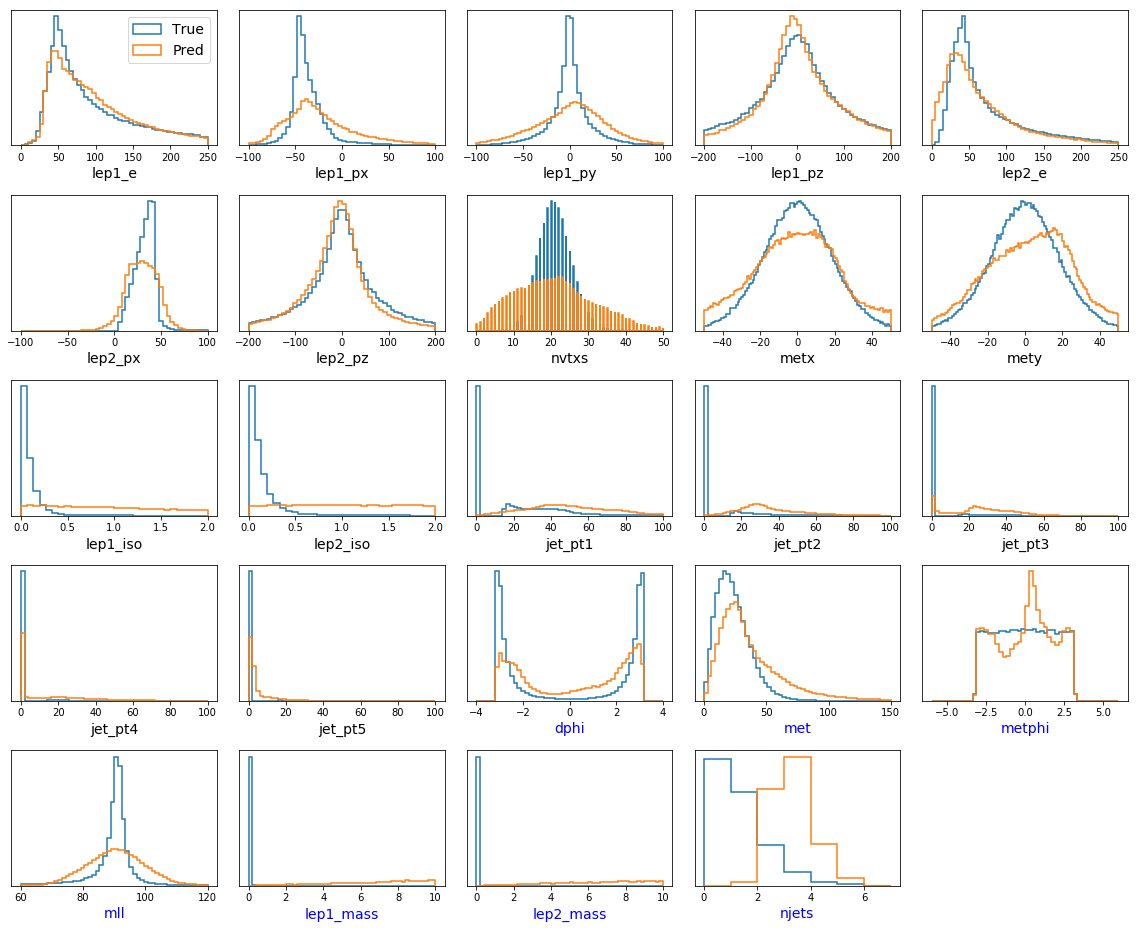

In [52]:
target_trial = 1
target_epoch = 13800
N=150000
if target_trial and target_epoch:
    gan.load_checkpoint(target_epoch, target_trial)
#gan.load_checkpoint(target_epoch)
preds = gan.predict(N,1.0)
make_plots(preds,gan.data[:N])
#gan.tag = "jetisoscaleRobust_mllwidth_flatNegNoise_%d" % target_trial 

In [ ]:
# gan.tag = "v5_default_scan_0"
gan.load_last_checkpoint()
print "Loaded"

In [ ]:
def smooth(x,window=31,npoly=2):
    from scipy.signal import savgol_filter
    return savgol_filter(x,window,npoly)

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4,figsize=(15,3))
# plot losses
ax1.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["d_loss"],color="C0",lw=0.5)
ax1.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["g_loss"],color="C1",lw=0.5)
ax1.plot(gan.d_epochinfo["epoch"],smooth(gan.d_epochinfo["d_loss"]),label="d loss (smoothed)",color="C0")
ax1.plot(gan.d_epochinfo["epoch"],smooth(gan.d_epochinfo["g_loss"]),label="g loss (smoothed)",color="C1")
ax1.legend()
# plot masses
ax2.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["mass_sig"],color="C0",lw=0.5)
ax2.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["mass_mu"],color="C1",lw=0.5)
ax2.plot(gan.d_epochinfo["epoch"],smooth(gan.d_epochinfo["mass_sig"]),label="Z width (smoothed)",color="C0")
ax2.plot(gan.d_epochinfo["epoch"],smooth(gan.d_epochinfo["mass_mu"]),label="Z mass (smoothed)",color="C1")
ax2.legend()
# plot ks metrics
ax3.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["ks"], lw=0.5,color="C0")
ax3.plot(gan.d_epochinfo["epoch"],smooth(gan.d_epochinfo["ks"]), label="KS metric (smooth)",color="C0")
ax3.legend();
# plot times
ax4.plot(gan.d_epochinfo["epoch"],1./60*(np.array(gan.d_epochinfo["time"])-gan.d_epochinfo["time"][0]), label="times [min]")
ax4.legend()

## Plot predictions and real events
Get the noise from the gan object, feed it into the generator, then also take true events (`data`)

In [ ]:
N = 15000
# frac = 0.0001 # 2 events
# frac = 0.00005 # 1 event
frac = 1.0
_, noise = gan.get_noise(N,max_true_samples_frac=frac)
# print preds.shape
preds = gan.generator.predict(noise,verbose=1)
make_plots(preds,gan.data[:N])

## Recarray
The real data (`gan.data`) is a recarray, so column indexing happens with `gan.data["lep1_px"]`.
The predictions from the generator are just normal matrices, so you have to do yucky things like `preds[:,7]`
and keep track of what that means. Use a helper function to get a `np.view` into the predictions so that
they columns can be accessed in the same way.

In [ ]:
def Z_pt(data,haspy2=False):
    pxsum = data["lep1_px"]+data["lep2_px"]
    if haspy2: pysum = data["lep1_py"]+data["lep2_py"]
    else: pysum = data["lep1_py"]
    return np.hypot(pxsum,pysum)

def Z_phi(data,haspy2=False):
    pxsum = data["lep1_px"]+data["lep2_px"]
    if haspy2: pysum = data["lep1_py"]+data["lep2_py"]
    else: pysum = data["lep1_py"]
    return np.arctan2(pysum,pxsum)

def dphiphi(phi1,phi2):
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi 
    return np.abs(dphi)


def met_phi(data):
    if "met" in data.dtype.names:
        return data["metphi"]
    else:
        return np.arctan2(data["mety"],data["metx"])
    
def met_pt(data):
    if "met" in data.dtype.names:
        return data["met"]
    else:
        return np.hypot(data["metx"],data["mety"])
    
def ht(data):
    return data["jet_pt1"]*(data["jet_pt1"] > 10) + \
           data["jet_pt2"]*(data["jet_pt2"] > 10) + \
           data["jet_pt3"]*(data["jet_pt3"] > 10) + \
           data["jet_pt4"]*(data["jet_pt4"] > 10) + \
           data["jet_pt5"]*(data["jet_pt5"] > 10)

def nvtx(data):
    if "mll" in data.dtype.names:
        return data.nvtxs
    else:
        return np.rint(data["nvtxs"])

In [ ]:
# plot Z_pT for predicted and real events# plot Z 
predsrec = get_recview(preds)
fig,ax = plt.subplots()
ax.hist(Z_pt(gan.data[:10000],haspy2=False), label="Z $p_{T}$ real",bins=np.linspace(0,100,50),histtype="step",density=True,lw=2)
ax.hist(Z_pt(predsrec,haspy2=False),label="Z $p_{T}$ fake",bins=np.linspace(0,100,50),histtype="step",density=True,lw=2)
ax.legend()
ax.set_title("Z-boson $p_T$ for real and fake events");

In [ ]:
fig,ax = plt.subplots()
lowpu_real_met  = met_pt(gan.data)[nvtx(gan.data) < 15]
highpu_real_met = met_pt(gan.data)[nvtx(gan.data) > 25]
lowpu_fake_met  = met_pt(predsrec)[nvtx(predsrec) < 15]
highpu_fake_met = met_pt(predsrec)[nvtx(predsrec) > 25]
bins = np.linspace(0,100,50)
_ = ax.hist(lowpu_real_met,label="low PU, real",bins=bins,histtype="step",density=True,lw=1.5)
_ = ax.hist(lowpu_fake_met,label="low PU, fake",bins=bins,histtype="step",density=True,lw=1.5)
_ = ax.hist(highpu_real_met,label="high PU, real",bins=bins,histtype="step",density=True,lw=1.5)
_ = ax.hist(highpu_fake_met,label="high PU, fake",bins=bins,histtype="step",density=True,lw=1.5)
_ = ax.legend()
# ax.set_yscale("log",nonposy="clip")
_ = ax.set_title("MET for low (nvtx<15) and high (nvtx>25) events")

In [ ]:
from scipy.stats import binned_statistic

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4), sharex=True,sharey=True)

bins = [np.linspace(15,75,15),np.linspace(15,75,15)]

ptj1 = gan.data["jet_pt1"]
zpt = Z_pt(gan.data)
good = (zpt > 15.) & (ptj1 > 15.)
_,_,_,im = ax1.hist2d(ptj1[good],zpt[good],label="real",bins=bins,normed=True) #, norm=LogNorm())
fig.colorbar(im,ax=ax1, format="%.0e")

vals,edges,_ = binned_statistic(ptj1[good],zpt[good],statistic="median",bins=bins[0])
xs = 0.5*(edges[1:] + edges[:-1])
ax1.plot(xs,vals,"ro-",color=(1.0,0.3,0.3),lw=1.,ms=4.5, label="median")
ax1.legend()

ptj1 = predsrec["jet_pt1"]
zpt = Z_pt(predsrec)
good = (zpt > 15.) & (ptj1 > 15.)
_,_,_,im = ax2.hist2d(ptj1[good],zpt[good],label="real",bins=bins,normed=True)
fig.colorbar(im,ax=ax2, format='%.0e')

vals,edges,_ = binned_statistic(ptj1[good],zpt[good],statistic="median",bins=bins[0])
xs = 0.5*(edges[1:] + edges[:-1])
ax2.plot(xs,vals,"ro-",color=(1.0,0.3,0.3),lw=1.,ms=4.5, label="median")
ax2.legend()

ax1.set_title("Real")
ax2.set_title("Fake")
ax1.set_ylabel("Z $p_{T}$")
ax1.set_xlabel("jet 1 $p_{T}$")
ax2.set_xlabel("jet 1 $p_{T}$")


fig.set_tight_layout(True)

In [ ]:
predmll = Minv(preds)
predmll = predmll[np.isfinite(predmll)]
bins = np.linspace(60,120,120)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,gridspec_kw={'height_ratios':[9, 2]})
hreal = ax1.hist(gan.data["mll"],bins=bins, label="real $m_{ll}$",histtype="step",density=True,lw=2)
hfake = ax1.hist(predmll,bins=bins, label="fake $m_{ll}$",histtype="step",density=True,lw=2)
ratio = hfake[0]/hreal[0]
ax2.plot(bins[:-1],ratio,marker="o",markersize=3,linewidth=1.5,linestyle="")
ax2.set_ylim([0.5,1.5])
ax2.set_ylabel("fake/real")
_ = ax1.legend()
realmll = gan.data["mll"]
print "real:",realmll.mean(), realmll.std()
print "fake:",predmll.mean(), predmll.std()

In [ ]:
jetmat = np.c_[predsrec["jet_pt1"],predsrec["jet_pt2"],predsrec["jet_pt3"],predsrec["jet_pt4"],predsrec["jet_pt5"]]
# njet counts just any jet with pt>15
njets1 = (jetmat > 15.).sum(axis=-1)
# njet counts only jets with pt>15 starting from first jet if all previous jets pass threshold
# e.g., if jetpt1>15, jetpt2<15, jetpt3>15, then njets==1 in second case, but 2 in first case
njets2 = (jetmat > 15.).argmin(axis=-1)
# turns out the two are very similar


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3), sharey=False)
for numer,denom,ax in [
    ["jet_pt2","jet_pt1",ax1],
    ["jet_pt3","jet_pt2",ax2],
    ["jet_pt4","jet_pt3",ax3],
]:
    jetratio_real = (gan.data[:N][numer]/gan.data[:N][denom])[(gan.data[:N][denom] > 15.) & (gan.data[:N][numer] > 15.)]
    jetratio_fake = (predsrec[numer]/predsrec[denom])[(predsrec[denom] > 15.) & (predsrec[numer] > 15.)]
    bins = np.linspace(0,4,60)
    ax.hist(jetratio_real,bins=bins,histtype="step",density=True,label="real",lw=1.5)
    ax.hist(jetratio_fake,bins=bins,histtype="step",density=True,label="fake",lw=1.5)
    ax.legend()
    ax.set_title("{} / {} ratio".format(numer,denom))
fig.set_tight_layout(True)

In [ ]:

import glob

picklenames = glob.glob("progress/jetisoscaleRobust_mllwidth_flatNegNoise*/*pkl")
def get_epochks(fname):
    with open(fname) as fh:
        data = pickle.load(fh)
        return np.array(data["epoch"]),np.array(data["ks"])
    return [],[]
#print dirnames
print get_epochks(picklenames[0])
fig,ax = plt.subplots()
for pn in picklenames:
    xs, ys = get_epochks(pn)
#     good = ys < 0.08
#     xs = xs[good]
#     ys = ys[good]
    print pn, xs[ys.argmin()], ys[ys.argmin()]
#     ax.plot(xs,ys, label=pn)
# ax.legend()